In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

# Add the parent directory (project root) to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

print(f"Added to path: {project_root}")

Added to path: D:\SPACE-BIOLOGY-KNOWLEDGE-ENGINE


In [3]:
from utils import show_prompt
from src.prompts import clarify_with_user_instructions
show_prompt(clarify_with_user_instructions, "Clarify with User Instructions")

╭──────────────────────────────────────── Clarify with User Instructions ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the messages that have been exchanged so far from the user asking for the report:                    │
│  <Messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  Assess whether you need to ask a clarifying question, or if the user has already provided enough information   │
│  for you to start research.                                                                                     │
│  IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you       │
│  almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.               │
│                                                                                                                 │
│  If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.                               │
│  If you need to ask a question, follow these guidelines:                                                        │
│  - Be concise while gathering all necessary information                                                         │
│  - Make sure to gather all the information needed to carry out the research task in a concise, well-structured  │
│  manner.                                                                                                        │
│  - Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown            │
│  formatting and will be rendered correctly if the string output is passed to a markdown renderer.               │
│  - Don't ask for unnecessary information, or information that the user has already provided. If you can see     │
│  that the user has already provided the information, do not ask for it again.                                   │
│                                                                                                                 │
│  Respond in valid JSON format with these exact keys:                                                            │
│  "need_clarification": boolean,                                                                                 │
│  "question": "<question to ask the user to clarify the report scope>",                                          │
│  "verification": "<verification message that we will start research>"                                           │
│                                                                                                                 │
│  If you need to ask a clarifying question, return:                                                              │
│  "need_clarification": true,                                                                                    │
│  "question": "<your clarifying question>",                                                                      │
│  "verification": ""                                                                                             │
│                                                       

In [4]:
%%writefile ../src/state_scope.py 

import operator 
from typing_extensions import Optional, Annotated, List, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

# ==== STATE DEFINITIONS ====

class AgentState(MessagesState):
    """
    Main state for the full multi-agent RAG system.
    Extends MessagesState with additional fields.
    """

    # Retrieval brief generated from user conversation history
    retrieval_brief: Optional[str]
    # Messages exchanges 
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # Raw unprocessed documents retrieved from vector DB
    raw_notes: Annotated[list[str], operator.add] = []
    # Processed notes after any cleaning or formatting
    notes: Annotated[list[str], operator.add] = []
    # Final formatted report
    final_report: Optional[str]

# ==== STRUCTURED OUTPUT SCHEMAS ====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decision and questions."""

    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question."
    )
    question: str = Field(
        description="A question to ask the user to clarify the retrieval scope."
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided necessary information."
    )

class RetrievalQuestion(BaseModel):
    """Schema for structured retrieval brief generation."""

    retrieval_brief: str = Field(
        description="A retrieval question that will be used to guide the retrieval."
    )

Overwriting ../src/state_scope.py


In [5]:
%%writefile ../src/retrieval_agent_scope.py

"""
User Clarification and Research Brief Generation

This module implements the scoping phase of the retrieval workflow, where we:
1. Assess if the user's request needs clarification. 
2. Generate a detailed research brief from the conversation. 

The workflow uses structured outputs to make deterministic decisions about 
whether sufficient context exists to proced with research. 
"""

from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from src.prompts import clarify_with_user_instructions, transform_messages_into_retrieval_topic_prompt
from src.state_scope import AgentState, ClarifyWithUser, RetrievalQuestion

from dotenv import load_dotenv
load_dotenv()

# ==== UTILITY FUNCTIONS ====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %#d, %Y")


# ==== CONFIGURATOIN ====

# Initialize model
model = init_chat_model(model="openai:gpt-4o-mini", temperature=0)

# ==== WORKFLOW NODES ====

def clarify_with_user(state: AgentState) -> Command[Literal["write_retrieval_brief", "__end__"]]:
    """
    Determine if the user's request contains sufficient information to proceed with retrieval.
    
    Uses structured output to make deterministic decisions and avoid hallucination.
    Routes to either research brief generation or ends with a clarification question.
    """

    # Set up structured output model
    structured_output_model = model.with_structured_output(ClarifyWithUser)

    # Invoke the model with clarification instructions
    response = structured_output_model.invoke([
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages=state["messages"]),
            date=get_today_str()
        ))
    ])

    # Route based on clssarification need
    if response.need_clarification:
        return Command(
            goto=END, 
            update={"messages": [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="write_retrieval_brief", 
            update={"messages": [AIMessage(content=response.verification)]}
        )

def write_retrieval_brief(state: AgentState):
    """
    Transform the conversation history into a comprehensive retrieval brief.

    Uses structured output to ensure the brief follows the required format
    and contains all necessary details for effective research.
    """

    # Set up structured output model
    structured_output_model = model.with_structured_output(RetrievalQuestion)

    # Generate retrieval brief from conversation history
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_retrieval_topic_prompt.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])

    # Update state with generated research brief and pass it to the supervisor
    return {
        "retrieval_brief": response.retrieval_brief,
        "supervisor_messages": [HumanMessage(content=f"{response.retrieval_brief}.")]
    }

# ==== GRAPH CONSTRUCTION ====

# Build the scoping nodes
retrieval_builder = StateGraph(AgentState)

# Add workflow nodes
retrieval_builder.add_node(clarify_with_user, name="clarify_with_user")
retrieval_builder.add_node(write_retrieval_brief, name="write_retrieval_brief")

# Add workflow edges
retrieval_builder.add_edge(START, "clarify_with_user")
retrieval_builder.add_edge("write_retrieval_brief", END)

# Compile the workflow
scope_research = retrieval_builder.compile()

Overwriting ../src/retrieval_agent_scope.py


d:\SPACE-BIOLOGY-KNOWLEDGE-ENGINE\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


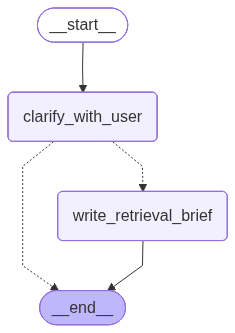

In [6]:
# Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from src.retrieval_agent_scope import retrieval_builder

checkpointer = InMemorySaver()
scope = retrieval_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [7]:
# Run the workflow
from utils import format_messages
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1"}}
result = scope.invoke({"messages": [HumanMessage(content="what is the effect of on bones ?")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ what is the effect of on bones ?                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you please specify what you are referring to when you mention 'the effect of on bones'? Are you asking    │
│ about a specific substance, activity, or condition?                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [10]:
result = scope.invoke({'messages': [HumanMessage(content="I am talking about effect of microgravity on bones.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ what is the effect of on bones ?                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you please specify what you are referring to when you mention 'the effect of on bones'? Are you asking    │
│ about a specific substance, activity, or condition?                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I am talking about effect of microgravity on bones.                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for clarifying that you are asking about the effect of microgravity on bones. I have sufficient       │
│ information to proceed with the research on this topic.                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [11]:
from rich.markdown import Markdown
Markdown(result["retrieval_brief"])

I would like to research the effects of microgravity on bones, specifically focusing on the physiological changes  
that occur in bone density, structure, and strength due to prolonged exposure to microgravity environments, such as
those experienced by astronauts in space. Please include scientific studies, articles, and papers that provide     
detailed insights into these effects.